# Lab Five: Wide and Deep Networks

#### Machine Learning in Python
    
Will Lacey - 45906124 - <strong>CSE7324</strong>
<br>
Roger Wong - 43867412 - <strong>CSE5324</strong>

## Preparation (40 points total)
<em>
    <strong>[10 points]</strong> Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 
</em>

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from copy import deepcopy

import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
from keras.layers import Embedding, Flatten, Concatenate
from keras.layers import concatenate
from keras.utils import to_categorical

from sklearn.decomposition import PCA
from sklearn import metrics as mt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.simplefilter('ignore')

In [2]:
try:
    df_mat = pd.read_csv('student-mat.csv') # read in the csv file
    df_por = pd.read_csv('student-por.csv') # read in the csv file
    df_mat['class'] = "math"
    df_por['class'] = "portuguese"
    df = pd.concat([df_mat, df_por], ignore_index=True)
    print("Succeeded to Open File.\n")
    df.romantic.replace(to_replace=['yes','no'], value=(0,1),inplace=True)
    print(df.info()) 
    
except IOError:
    print("Failed to Open Files. Quitting Program.")
    sys.exit

Succeeded to Open File.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 34 columns):
school        1044 non-null object
sex           1044 non-null object
age           1044 non-null int64
address       1044 non-null object
famsize       1044 non-null object
Pstatus       1044 non-null object
Medu          1044 non-null int64
Fedu          1044 non-null int64
Mjob          1044 non-null object
Fjob          1044 non-null object
reason        1044 non-null object
guardian      1044 non-null object
traveltime    1044 non-null int64
studytime     1044 non-null int64
failures      1044 non-null int64
schoolsup     1044 non-null object
famsup        1044 non-null object
paid          1044 non-null object
activities    1044 non-null object
nursery       1044 non-null object
higher        1044 non-null object
internet      1044 non-null object
romantic      1044 non-null int64
famrel        1044 non-null int64
freetime      1044 non-null int64
go

In [3]:
target = df[['G1', 'G2', 'G3']].mean(axis=1)
target[(target < 10)] = 0
target[(target >= 10)] = 1

data = df.drop(
    columns=[
        'G1',
        'G2',
        'G3'
])

df_train = deepcopy(df)
df_test = deepcopy(df)
X = deepcopy(df)
y = target

In [4]:
col_names = df_train.columns.values

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=64)
for train_idx, test_idx in sss.split(df_train.values, y.values):
    # X_train - 80% training attribute set
    # X_test - 20% test attribute set
    # y_train - 80% training labels
    # y_test - 20% training labels
    X_train, X_test = pd.DataFrame(X.values[train_idx], columns=col_names), pd.DataFrame(X.values[test_idx], columns=col_names)
    y_train, y_test = pd.DataFrame(y.values[train_idx], columns=["grades"]), pd.DataFrame(y.values[test_idx], columns=["grades"])

y_train, y_test = y_train.values.flatten(), y_test.values.flatten()

In [5]:
encoders = dict()
categorical_headers = ['school','sex','address',
                       'famsize','Pstatus','Mjob', 'Fjob','reason','guardian',
                       'schoolsup','famsup', 'paid','activities','nursery',
                       'higher','internet']


In [6]:
for col in categorical_headers:
    X_train[col] = X_train[col].str.strip()
    X_test[col] = X_test[col].str.strip()

    encoders[col] = LabelEncoder() # save the encoder
    X_train[col+'_int'] = encoders[col].fit_transform(X_train[col])
    X_test[col+'_int'] = encoders[col].transform(X_test[col])



In [7]:
numeric_headers = ["age", "Medu", "Fedu","traveltime", 
                   "studytime","failures", "famrel", 
                   "freetime","goout", "Dalc",
                  "Walc","health", "absences", "romantic"]

for col in numeric_headers:
    X_train[col] = X_train[col].astype(np.float)
    X_test[col] = X_test[col].astype(np.float)
    
    ss = StandardScaler()
    X_train[col] = ss.fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = ss.transform(X_test[col].values.reshape(-1, 1))
    
X_test.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Fjob_int,reason_int,guardian_int,schoolsup_int,famsup_int,paid_int,activities_int,nursery_int,higher_int,internet_int
0,GP,F,0.229943,U,GT3,T,1.241158,1.451243,services,teacher,...,4,1,1,0,1,0,0,1,1,1
1,MS,F,1.046974,U,LE3,A,-1.418467,-1.265770,at_home,services,...,3,0,1,0,0,0,0,1,1,0
2,GP,M,-0.587088,U,LE3,T,-0.531925,-0.360099,other,other,...,2,1,1,0,0,0,0,1,1,1
3,GP,F,0.229943,U,GT3,T,-1.418467,-1.265770,at_home,other,...,2,3,1,0,1,0,1,1,1,0
4,GP,F,0.229943,R,GT3,T,1.241158,1.451243,services,services,...,3,3,1,0,1,0,1,1,1,1


In [8]:
ohe = OneHotEncoder()
categorical_headers_ints = [x+'_int' for x in categorical_headers]
feature_columns = categorical_headers_ints+numeric_headers
X_train_ohe = ohe.fit_transform(X_train[categorical_headers_ints].values)
X_test_ohe = ohe.transform(X_test[categorical_headers_ints].values)
X_train_num =  X_train[numeric_headers].values
X_test_num = X_test[numeric_headers].values

# the ohe instance will help us to organize our encoded matrix
print(ohe.feature_indices_)
print(X_train_ohe.shape)
print(type(X_train_ohe), '========THIS IS SPARSE ENCODED=======')

[ 0  2  4  6  8 10 15 20 24 27 29 31 33 35 37 39 41]
(835, 41)
<class 'scipy.sparse.csr.csr_matrix'> ========THIS IS SPARSE ENCODED=======


<em>
    <strong>[10 points]</strong> Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed). 
</em>

The groups of features in our data that we combined are: school, address, activities, internet, Mjob, Fjob, Pstatus, reason, famsize, famsup, paid, nursery, and schoolsup
We want to help our model memorize our training data. Most of the reasons for combining these features are pretty arbitrary and subjective 
We combined school and address into one cross product features since we believe that most people would want to go to school closer to where they live, thus providing a correlation.
We combined activities and internet becasue these suggests that students have free time
We combined Mjob, Fjob, Pstatus, and reason because we believe there must be some correlation 
We combined famsize, famsup, paid, nursery, and schoolsup because they are similar in helping to determine a student's upbringing and financial status 

<em>
    <strong>[10 points]</strong> Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
</em>

We will be using Precision_score as our evaluation metric because we want lower false positives. We don't want the program to classify failing students as passing. If this happens, the failing students don't get the necessary resources the school can provide. We will also weight our confusion matrix so the program pays attention to those who are failing and provides more priority towards those students.

In [9]:
print('weight metric calculation: ')
total = len(target)
failing = len(target[target == 0]) # num of instances
passing = len(target[target == 1]) # num of instances

fail_weight = total / failing 
pass_weight = total / passing

print('fail_weight: ', fail_weight)
print('pass_weight: ', pass_weight)


weight metric calculation: 
fail_weight:  3.2523364485981308
pass_weight:  1.4439834024896265


<em>
    <strong>[10 points]</strong> Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 
</em>


We shuffle our data in the beginning to split our training and testing data into an 80/20 split. Because our data isn't time sensitive, we believe that an 80/20 split is sufficient for training our classifier. Although this will only leave us with 800 instances to train on, which isn't very high, we believe this is still better than having a 90/10 split. Although we don't as much trainng data as we hope to have, we will have better understanding of how well our program does with the other 200 instances. The reason for this split is because Then while we test out each data architecture, we will use stratified 5-fold cross validation because we only have data from 1000 students. We want each fold to have an equal distribution of pass and fail students.     

## Modeling (50 points total)
<em>
    <strong>[20 points]</strong> Create several combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.
</em>

### First Deep Architecture  

In [10]:
%%time

cross_columns = [['school','address', ],
                 ['activities', 'internet'],
                 ['Mjob','Fjob','Pstatus', 'reason'],
                 ['famsize','famsup','paid','nursery','schoolsup']]


# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1)(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='relu',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1)(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dropout(0.25, seed=32, name='dropout75')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dropout(0.50, seed=32, name='dropout50')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
deep_branch = Dropout(0.75, seed=32, name='dropout25')(deep_branch)

final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

X_train_final = X_ints_train
X_train_final.append(X_train_num)

# Weighted Values for each class; Sets them Equal to eachother (Since they are unequal in count)
class_weight = {
    0: 3.25,
    1: 1.44,
}

costs = []
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=64)
for train_idx, test_idx in kfold.split(X_train_num, y_train):
    # build train and test samples from crossed cols and feature cols
    X_train_temp = [X[train_idx] for X in X_train_final]
    y_train_temp = y_train[train_idx]
    X_test_temp = [X[test_idx] for X in X_train_final]
    y_test_temp = y_train[test_idx]
    
    # rebuild model
    model = Model(inputs=all_inputs, outputs=final_branch)
    model.compile(optimizer='adagrad',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # fit on train and predict on test
    model.fit(X_train_temp, y_train_temp, class_weight=class_weight, epochs=100, batch_size=32, verbose=0)
    yhat = np.round(model.predict(X_test_temp))

    # take cost
    c = mt.precision_score(y_test_temp, yhat)
    costs.append(c)
    
    # print confusion matrix
    print(confusion_matrix(y_test_temp,yhat), "=>", c)

print(costs)

[[30 22]
 [54 62]] => 0.7380952380952381
[[34 18]
 [33 83]] => 0.8217821782178217
[[ 33  18]
 [ 13 103]] => 0.8512396694214877
[[ 38  13]
 [ 12 103]] => 0.8879310344827587
[[42  9]
 [16 99]] => 0.9166666666666666
[0.7380952380952381, 0.8217821782178217, 0.8512396694214877, 0.8879310344827587, 0.9166666666666666]
CPU times: user 1min 2s, sys: 18.9 s, total: 1min 21s
Wall time: 37.1 s


In [11]:
X_test_final = X_ints_test
X_test_final.append(X_test_num)
model = Model(inputs=all_inputs, outputs=final_branch)
model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [12]:
%%time

history = model.fit(X_train_final, y_train, class_weight=class_weight, 
                    epochs=1250, batch_size=32, verbose=0,
                    validation_data = (X_test_final, y_test))

CPU times: user 3min 15s, sys: 1min 8s, total: 4min 23s
Wall time: 1min 41s


Text(0.5, 0, 'epochs')

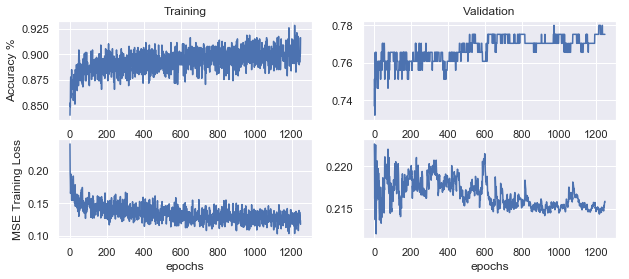

In [13]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

In [14]:
yhat_proba = model.predict(X_test_final)
yhat = np.round(yhat_proba)
print(confusion_matrix(y_test,yhat))
print(mt.precision_score(y_test, yhat))
fpr1, tpr1, _ = roc_curve(y_test, yhat_proba)
roc_auc1 = auc(fpr1, tpr1)

[[ 33  31]
 [ 16 129]]
0.80625


### Second Architecture with Crossed Columns 

In [15]:
%%time

cross_columns = [['school','address', ],
                 ['activities', 'internet'],
                 ['Mjob','Fjob','Pstatus', 'reason'],
                 ['famsize','famsup','paid','nursery','schoolsup']]


# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1)(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='relu',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dropout(0.10, seed=32, name='dropout10')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dropout(0.20, seed=32, name='dropout20')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep3')(deep_branch)
deep_branch = Dropout(0.30, seed=32, name='dropout30')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep4')(deep_branch)
deep_branch = Dropout(0.40, seed=32, name='dropout40')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep5')(deep_branch)
deep_branch = Dropout(0.50, seed=32, name='dropout50')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep6')(deep_branch)
deep_branch = Dropout(0.60, seed=32, name='dropout60')(deep_branch)    
    
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

X_train_final = X_ints_train
X_train_final.append(X_train_num)

# Weighted Values for each class; Sets them Equal to eachother (Since they are unequal in count)
class_weight = {
    0: 3.25,
    1: 1.44,
}

costs = []
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=64)
for train_idx, test_idx in kfold.split(X_train_num, y_train):
    # build train and test samples from crossed cols and feature cols
    X_train_temp = [X[train_idx] for X in X_train_final]
    y_train_temp = y_train[train_idx]
    X_test_temp = [X[test_idx] for X in X_train_final]
    y_test_temp = y_train[test_idx]
    
    # rebuild model
    model = Model(inputs=all_inputs, outputs=final_branch)
    model.compile(optimizer='adagrad',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # fit on train and predict on test
    model.fit(X_train_temp, y_train_temp, class_weight=class_weight, epochs=100, batch_size=32, verbose=0)
    yhat = np.round(model.predict(X_test_temp))

    # take cost
    c = mt.precision_score(y_test_temp, yhat)
    costs.append(c)
    
    # print confusion matrix
    print(confusion_matrix(y_test_temp,yhat), "=>", c)

print(costs)

[[26 26]
 [29 87]] => 0.7699115044247787
[[38 14]
 [24 92]] => 0.8679245283018868
[[ 38  13]
 [  9 107]] => 0.8916666666666667
[[ 42   9]
 [  9 106]] => 0.9217391304347826
[[44  7]
 [16 99]] => 0.9339622641509434
[0.7699115044247787, 0.8679245283018868, 0.8916666666666667, 0.9217391304347826, 0.9339622641509434]
CPU times: user 1min 25s, sys: 23.3 s, total: 1min 48s
Wall time: 51.3 s


In [16]:
X_test_final = X_ints_test
X_test_final.append(X_test_num)
model = Model(inputs=all_inputs, outputs=final_branch)
model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [17]:
%%time

history = model.fit(X_train_final, y_train, class_weight=class_weight, 
                    epochs=1250, batch_size=32, verbose=0,
                    validation_data = (X_test_final, y_test))

CPU times: user 4min 14s, sys: 1min 24s, total: 5min 39s
Wall time: 2min 11s


Text(0.5, 0, 'epochs')

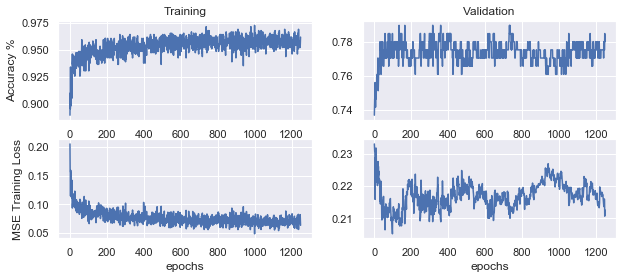

In [18]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

In [19]:
yhat_proba = model.predict(X_test_final)
yhat = np.round(yhat_proba)
print(confusion_matrix(y_test,yhat))
print(mt.precision_score(y_test, yhat))
fpr2, tpr2, _ = roc_curve(y_test, yhat_proba)
roc_auc2 = auc(fpr2, tpr2)

[[ 33  31]
 [ 15 130]]
0.8074534161490683


<em>
    <strong>[20 points]</strong> Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly. 
</em>

We compared between a 3 deep layer network and a 7 deep layer network. For each network, we printed out our evalutaion metric for each fold. As you can see in the 3 layer network, the scores range from 0.73-0.88 while the scores in the 7 layer network range from 0.77-0.93. We can tell from this information that the 7 layer network is performing statistically better than the 3 layer network using our cross validation and evaluation metric. The validation and epoch graphs for the 7 layer network appear to be more consistent and correct than the 3 layer network's graphs. There are more defined curves in the seven layer network than the three layer network also. 

<em>
    <strong>[10 points]</strong> Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). For classification tasks, use the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical method to compare the performance of different models.  
</em>

In [20]:
def one_hot_encode(df, feature):
    one_hot = pd.get_dummies(df[feature], prefix = feature)
    df = df.drop([feature], axis=1)
    df = pd.concat([df, one_hot], axis=1)
    return df

def binary_encode(df, feature):
    binary = pd.get_dummies(df[feature], prefix = feature)
    df = df.drop([feature], axis=1)
    df = pd.concat([df, binary.iloc[:,0]], axis=1)
    return df

# Original Header Names Prior to Encoding
original_headers = list(df.columns.values)

# List of headers to be binary encoded
binary_headers = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup',
                  'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
                  'romantic', 'class']

# List of headers to be one hot encoded
one_hot_headers = ['age', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 
                   'traveltime', 'studytime', 'famrel', 'freetime', 'goout', 'Dalc',
                   'Walc', 'health', 'absences', 'failures']

# Convert absences into few, some, and a lot of absences
data.absences[(data.absences  <= 5)] = 0
data.absences[(data.absences > 5 ) & (data.absences <= 10)] = 1
data.absences[(data.absences  > 10)] = 2

# binary ecodes
for header in binary_headers:
    data = binary_encode(data, header)

# one hot ecodes
for header in one_hot_headers:
    data = one_hot_encode(data, header)

# Encoded Headers
encoded_headers = list(data.columns.values)
    
data.shape

(1044, 94)

In [21]:
def network_fit(nn, X_train, y_train, X_test, y_test):
    history = nn.fit(X_train,
                      y_train, 
                      epochs=1250, 
                      batch_size=50, 
                      verbose=0, 
                      validation_data = (X_test, y_test)
    )
    return history

def network_predict(nn, X_test, y_test):
    yhat_proba = nn.predict(X_test)
    yhat = np.round(yhat_proba)
    confusion = mt.confusion_matrix(y_test, yhat)
    acc = mt.precision_score(y_test, yhat)
    fpr, tpr, _ = roc_curve(y_test, yhat_proba)
    roc_auc = auc(fpr, tpr)
    return confusion, acc, fpr, tpr, roc_auc

def network_plot(history):    
    plt.figure(figsize=(15,5))

    # summarize history for accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

In [22]:
split = int(len(data) * 0.8)

X_train = data.values[0:split]
X_test = data.values[split:len(data)]
y_train = target.values[0:split]
y_test = target.values[split:len(data)]

In [23]:
inputs = Input(shape=(X_train.shape[1],), name='Input')
layer1 = Dense(units=100, activation='relu', name='Layer_1')(inputs)
layer1 = Dropout(0.25, name='Dropout_25')(layer1)
layer2 = Dense(units=50, activation='relu', name='Layer_2')(layer1)
layer2 = Dropout(0.50, name='Dropout_50')(layer2)
layer3 = Dense(units=50, activation='relu', name='Layer_3')(layer2)
layer3 = Dropout(0.75, name='Dropout_75')(layer3)
layer4 = Dense(units=10, activation='relu', name='Layer_4')(layer3)
predictions = Dense(units=1, activation='sigmoid', name='Activation')(layer4)

mlp = Model(inputs=inputs, outputs=predictions)

mlp.compile(loss='mean_squared_error',
              optimizer='adagrad',
              metrics=['accuracy'])

mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 94)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 100)               9500      
_________________________________________________________________
Dropout_25 (Dropout)         (None, 100)               0         
_________________________________________________________________
Layer_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
Dropout_50 (Dropout)         (None, 50)                0         
_________________________________________________________________
Layer_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
Dropout_75 (Dropout)         (None, 50)                0         
__________

In [24]:
%%time

history = network_fit(mlp, X_train, y_train, X_test, y_test)

CPU times: user 1min 5s, sys: 14.8 s, total: 1min 20s
Wall time: 36.9 s


In [25]:
confusion, acc, fpr, tpr, roc_auc = network_predict(mlp, X_test, y_test)
print(confusion, acc)

[[ 23  69]
 [  4 113]] 0.6208791208791209


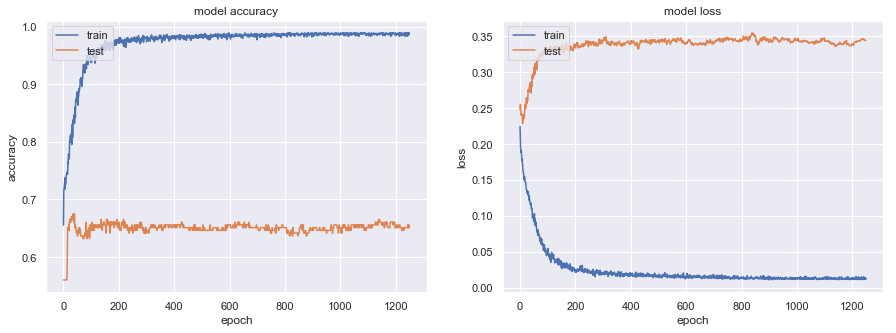

In [26]:
network_plot(history)

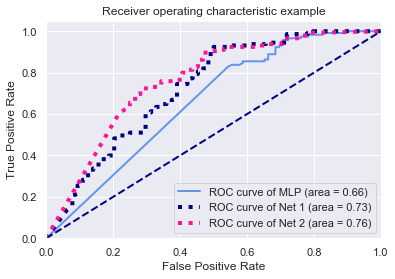

In [27]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='cornflowerblue',
         lw=lw, label='ROC curve of MLP (area = %0.2f)' % roc_auc)

plt.plot(fpr1, tpr1, color='navy', linestyle=':', linewidth=4,
         lw=lw, label='ROC curve of Net 1 (area = %0.2f)' % roc_auc1)

plt.plot(fpr2, tpr2, color='deeppink', linestyle=':', linewidth=4,
         lw=lw, label='ROC curve of Net 2 (area = %0.2f)' % roc_auc2)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Net1 is the 3 layer network and Net 2 is the 7 layer network. We want our curves to be as close to the upper length quadrant of the graph. In the graph above, all of our curves are above the random guessing line so that's good. As you can see, the area under the curve for Net 2 is greater than that of the MLP and Net 1. Net 2 is closest to the ideal line. This ultimately allows us to conclude that Net 2 yields a greater performance than the other two.

## Exceptional Work (10 points total)
<em>
    One idea (required for 7000 level students): Capture the embedding weights from the deep network and (if needed) perform t-SNE dimensionality reduction on the output of these embedding layers (only if needed). That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data.</em>

In the following cell, we capture the categorical embedded weights of our second wide-deep network architecture.

In [69]:
weights_cat_int = []
embed_titles = []
for l in model.layers:
    if '_embed' in l.name:
        if l.name != 'concat_embeds':
            print(l.name)
            embed_titles.append(l.name)
            # Returns a list of one array
            weights = l.get_weights()
            
            # Remove list format of array
            weights = weights[0]
            
            # Capture the embeddings of the weights
            embed1 = weights[0][0]
            embed2 = weights[1][0]
            weights_cat_int.append([embed1,embed2])
    

school_int_embed
sex_int_embed
address_int_embed
famsize_int_embed
Pstatus_int_embed
Mjob_int_embed
Fjob_int_embed
reason_int_embed
guardian_int_embed
schoolsup_int_embed
famsup_int_embed
paid_int_embed
activities_int_embed
nursery_int_embed
higher_int_embed
internet_int_embed


In [64]:
weights_cat_int

[[-0.14095397, 0.15852907],
 [0.26671478, -0.14845312],
 [-0.12955588, 0.08156386],
 [-0.16359897, 0.012716597],
 [0.49898273, -0.07183353],
 [0.013363509, -0.01173],
 [-0.28033778, 0.0030941414],
 [0.16617963, -0.07341247],
 [0.24184528, -0.03940629],
 [-0.11427004, 0.24448292],
 [0.09203553, -0.12178429],
 [-0.22168279, 0.27490622],
 [0.2194105, -0.07132686],
 [-0.26980662, 0.10148663],
 [-0.3542229, 0.021018468],
 [-0.33112288, 0.0011887274]]

In [65]:
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(weights_cat_int.copy())
weights_cat_int_pca = pca.transform(weights_cat_int)

print ('pca:', pca.components_)

pca: [[ 0.94948544 -0.3138111 ]
 [ 0.3138111   0.94948544]]


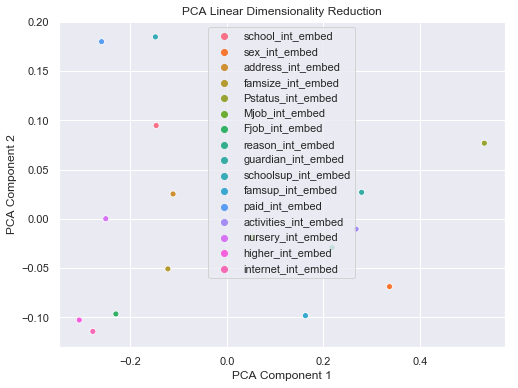

In [71]:
plt.figure(figsize=(8,6))

sns.scatterplot(weights_cat_int_pca[:,0], weights_cat_int_pca[:,1], hue=embed_titles)
plt.title('PCA Linear Dimensionality Reduction')
plt.xlabel('PCA Component 1') 
plt.ylabel('PCA Component 2')
plt.show()

We performed PCA on the embedded weights. We ultimately ran out of time and were unable to perform t-SNE on the embeddings. The graph above clearly shows no correlation in weights.